In [44]:
# Hyperparameters
seq_length = 30 #window
batch_size = 16
hidden_size = 3  # Number of neurons in the hidden layers
num_layers = 1  # Number of hidden layers
learning_rate = 0.0001
num_epochs = 200
starting_point =  50 #cutoff first 50 points

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt
import math

In [46]:
def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def denormalize(normalized_train, params):
    mins = params['mins']
    maxs = params['maxs']
    denormalized_train = normalized_train * (maxs - mins) + mins    
    return denormalized_train

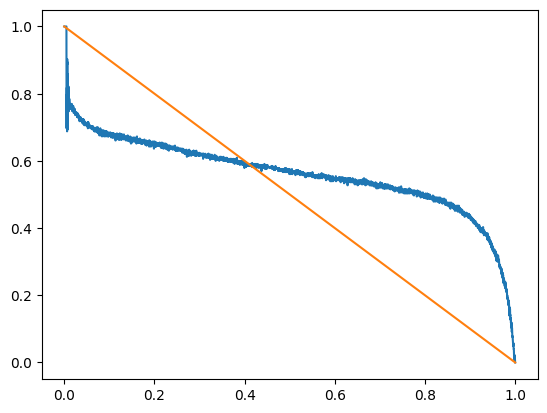

In [62]:
#"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)  
    return signal, tleft, t
#"""

"""
f_num = math.floor(len(signal)/seq_length)
    signal = signal[:f_num*seq_length]
    tleft = tleft[:f_num*seq_length]
    t = np.empty(0)
    t_ap = np.arange(0, seq_length)*100
    for i in range(f_num):
        t = np.append(t, t_ap)

        
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
"""

train_data = load_data('data/31-1-25/')
test_data = load_data('data/5-2-25/')
train_data, train_param = normalize(train_data)
test_data, test_param = normalize(test_data)
plt.plot(train_data[2], train_data[0])
plt.plot(train_data[2], train_data[1])
plt.show()

In [48]:
def prep_data(data, seq_length, step=1):
    input_data = data[0]
    output_data = data[1]
    time_data = data[2]
    xs, ys = [], []
    for i in range(starting_point, len(input_data) - seq_length, step):
        x = input_data[i:i + seq_length]
        y = output_data[i:i + seq_length]
        #t = time_data[i:i + seq_length]
        t = np.linspace(0, 1, seq_length)
        
        slope2, slope, intercept = np.polyfit(t, x, 2)
        mean = np.mean(x)
        std = np.std(x)
        xs.append((slope2, slope, intercept, mean, std))

        slope2, slope, intercept = np.polyfit(t, y, 2)
        mean = np.mean(y)
        std = np.std(y)
        ys.append((slope2, slope, intercept, mean, std))
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prep_data(train_data, seq_length)
X_test, y_test = prep_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [49]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

In [50]:
# Define the MLP model
'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
'''

'\nclass MLP(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(MLP, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size)\n        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)\n        self.fc3 = nn.Linear(hidden_size // 2, output_size)\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        out = self.fc1(x)\n        out = self.relu(out)\n        out = self.fc2(out)\n        out = self.relu(out)\n        out = self.fc3(out)\n        return out\n'

In [51]:
#'''
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer
        self.relu = nn.ReLU()  # Activation function
        self.prelu = nn.PReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)  # Pass through the hidden layer
        #out = self.relu(out)  # Apply ReLU activation
        out = self.tanh(out)
        out = self.fc2(out)  # Pass through the output layer
        return out
#'''

In [52]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [53]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/200], Loss: 0.0258
Epoch [20/200], Loss: 0.0204
Epoch [30/200], Loss: 0.0161
Epoch [40/200], Loss: 0.0121
Epoch [50/200], Loss: 0.0091
Epoch [60/200], Loss: 0.0073
Epoch [70/200], Loss: 0.0064
Epoch [80/200], Loss: 0.0059
Epoch [90/200], Loss: 0.0056
Epoch [100/200], Loss: 0.0052
Epoch [110/200], Loss: 0.0049
Epoch [120/200], Loss: 0.0046
Epoch [130/200], Loss: 0.0043
Epoch [140/200], Loss: 0.0041
Epoch [150/200], Loss: 0.0038
Epoch [160/200], Loss: 0.0035
Epoch [170/200], Loss: 0.0033
Epoch [180/200], Loss: 0.0030
Epoch [190/200], Loss: 0.0028
Epoch [200/200], Loss: 0.0026


Trenovaci
1.056311011314392
1.107628583908081
1.022701621055603
0.9720523357391357
0.9855808019638062
0.9184077978134155
0.8999462127685547
0.8969128131866455
0.8504643440246582
0.8518973588943481
0.84515380859375
0.8252308368682861
0.8132805824279785
0.8065564632415771
0.7811120748519897
0.8100168704986572
0.8138562440872192
0.7907077074050903
0.797075629234314
0.7604410648345947
0.7728087902069092
0.7743257284164429
0.7615464925765991
0.7474762201309204
0.7649610042572021
0.7778730392456055
0.7393473386764526
0.7285528182983398
0.7052323818206787
0.7485356330871582
0.7163577079772949
0.70949387550354
0.7063095569610596
0.6901167631149292
0.704113245010376
0.7018511295318604
0.6782939434051514
0.6767148971557617
0.6872860193252563
0.6464321613311768
0.6693717241287231
0.6435664892196655
0.6432472467422485
0.6458152532577515
0.6162130832672119
0.6215527057647705
0.6234102249145508
0.6309976577758789
0.6088672876358032
0.6080540418624878
0.5986286401748657
0.6127655506134033
0.578188776

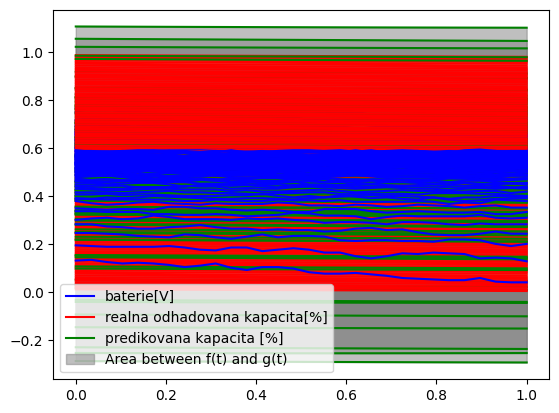

Testovaci
0.9985809326171875
0.9419229030609131
0.9450819492340088
0.9260993003845215
0.8936030864715576
0.8348435163497925
0.8387045860290527
0.8069146871566772
0.7973768711090088
0.7995678186416626
0.807816743850708
0.7658421993255615
0.783801794052124
0.7206398248672485
0.7034198045730591
0.7361290454864502
0.7519415616989136
0.7544815540313721
0.7225879430770874
0.6992000341415405
0.6888613700866699
0.647819995880127
0.6646840572357178
0.684262752532959
0.6757304668426514
0.6664199829101562
0.6679019927978516
0.6704381704330444
0.6167421340942383
0.6361128091812134
0.6678316593170166
0.6550416946411133
0.6226620674133301
0.6091657876968384
0.6015077829360962
0.5588697195053101
0.5665379762649536
0.6040834188461304
0.5896667242050171
0.6148494482040405
0.5964504480361938
0.5629515647888184
0.5489448308944702
0.5410994291305542
0.5698283910751343
0.550961971282959
0.5837485790252686
0.5650182962417603
0.542069673538208
0.5193753242492676
0.4939679801464081
0.5214862823486328
0.531892

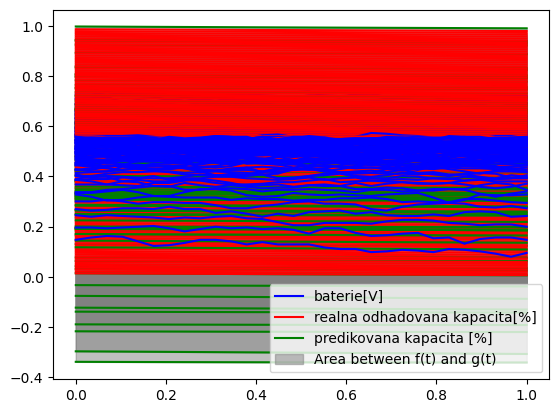

In [64]:
#slope2, slope, intercept, mean, std

def eval(data):
    model.eval()
    with torch.no_grad():
        
        input_data = data[0]
        output_data = data[1]
        #time_data = data[2]
        #time_data = t = np.linspace(0, len(data[1])/seq_length, len(data[1]))
        for i in range(starting_point, len(input_data) - seq_length, seq_length):
            x = input_data[i:i + seq_length]
            #t = time_data[i:i + seq_length]
            t = np.linspace(0, 1, seq_length)
            y = output_data[i:i + seq_length]
            #print(f"x data: {x}")
            #print(f"t data: {t}")

            slope2, slope, intercept = np.polyfit(t, x, 2)
            mean = np.mean(x)
            std = np.std(x)
            #slope = slope*10**(5)
            #slope2 = slope2*10**(8)
            #std = std*10**(1)
            X = torch.tensor((slope2, slope, intercept, mean, std), dtype=torch.float32)
            #print(f"X = {X}")
            pred = model(X).numpy()
            #reg = 10**(-8)*pred[0]*t**2 + 10**(-5)*pred[1]*t + pred[2] #Unscaling the numbers back
            reg = pred[0]*t**2 + pred[1]*t + pred[2] #Unscaling the numbers back
            #print(f"error: {np.mean(np.abs(y - reg))}")
            print(reg[0])
            
            plt.plot(t, x, c='blue', label="baterie[V]")
            plt.plot(t, y, c='red', label="realna odhadovana kapacita[%]")
            plt.plot(t, reg, c='green', label="predikovana kapacita [%]")
            plt.fill_between(t, y, reg, color='gray', alpha=0.5, label='Area between f(t) and g(t)')
            if (i <= starting_point): #otherwise it will print more than once
                plt.legend()
            #plt.scatter(t[0], intercept + np.absolute(intercept-pred[2]))
            #plt.scatter(t[0], pred[3], color="black", linewidth=1)
        plt.show()

print("Trenovaci")
eval(train_data)
#plt.savefig("pow_train.png")
print("Testovaci")
eval(test_data)
#plt.savefig("pow_test.png")

In [63]:
# Save the state dictionary and architecture parameters
checkpoint = {
    'seq_length': seq_length,
    'num_layers': num_layers,
    'starting_point': starting_point,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size,
    'state_dict': model.state_dict(),
}
torch.save(checkpoint, 'bat_model.pth')